## Build a Streamlit Chatbot using Langchain, ColBERT, Ragatouille, and ChromaDB!

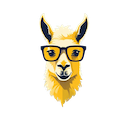

Instructions:
To successfully run this app, make sure you have the following two API keys: Together AI and ngrok.

Follow these steps:
- Replace the placeholders in the code with your actual API keys. Locate the text:

INSERT YOUR TOGETHER AI API KEY HERE
INSERT YOUR NGROK API KEY HERE

and replace them with your Together AI and ngrok API keys, respectively.

- After replacing the keys, execute all the cells in the code.

- Once the code is executed, ngrok will generate a link for the Streamlit app. Use this link to access and interact with the app.



### Install Dependencies

In [ ]:
!pip install streamlit langchain sentence-transformers pypdf chromadb --quiet

In [ ]:
!pip install -U ragatouille --quiet
!pip uninstall --y faiss-cpu & pip install faiss-gpu --quiet

### Create ColBERT index using Ragatouille

In [ ]:
!wget https://arxiv.org/pdf/2005.11401.pdf

In [ ]:
## ragatouille/colbert implmentation
from ragatouille import RAGPretrainedModel
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("2005.11401.pdf")
r_docs = loader.load_and_split()

RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

ragatouille_docs = [str(doc) for doc in r_docs]

RAG.index(
  collection=ragatouille_docs,
  index_name="langchain-index",
  max_document_length=512,
  split_documents=True,
)

### Build Streamlit App

In [ ]:
!wget https://i.ibb.co/B6vMCY0/logo-2-final-no-bg.png

In [27]:
%%writefile chat_pdf_app.py

import os
import json
import re
import tempfile
import streamlit as st
from PIL import Image

from langchain.document_loaders import PyPDFLoader
from langchain.memory.chat_message_histories import StreamlitChatMessageHistory
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.callbacks.base import BaseCallbackHandler
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts.prompt import PromptTemplate
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain import LLMChain, PromptTemplate
from langchain.retrievers import EnsembleRetriever
from ragatouille import RAGPretrainedModel
from langchain.llms import Together

TOGETHER_API_KEY = "INSERT YOUR TOGETHER AI API KEY HERE"      ## You can get your key from here: https://together.ai/

favicon = Image.open("logo-2-final-no-bg.png")

st.set_page_config(page_title="RAG with Mixtral 8x7B and ColBERT", page_icon=favicon)
st.sidebar.image("logo-2-final-no-bg.png", use_column_width=True)
with st.sidebar:
    st.write("**RAG with Mixtral 8x7B and ColBERT**")

# langsmith configuration (recommended)
# os.environ["LANGCHAIN_PROJECT"] = "ADD YOUR PROJECT NAME HERE"
# os.environ["LANGCHAIN_API_KEY"] = "INSERT YOUR LANGCHAIN API KEY HERE"          ## You can request access from here: https://smith.langchain.com/
# os.environ["LANGCHAIN_ENDPOINT"] ="https://api.smith.langchain.com"
# os.environ["LANGCHAIN_TRACING_V2"] = "true"


@st.cache_resource(ttl="1h")
def configure_retriever(uploaded_files):
    # read documents
    docs = []
    temp_dir = tempfile.TemporaryDirectory()
    for file in uploaded_files:
        temp_filepath = os.path.join(temp_dir.name, file.name)
        with open(temp_filepath, "wb") as f:
            f.write(file.getvalue())
        loader = PyPDFLoader(temp_filepath)
        docs.extend(loader.load())

    # split documents
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    splits = text_splitter.split_documents(docs)

    # create embeddings and store in vectordb
    embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-large-en-v1.5")
    vectordb = Chroma.from_documents(splits, embeddings)

    # define retriever
    chroma_retriever = vectordb.as_retriever(
        search_type="mmr", search_kwargs={"k": 4, "fetch_k": 10}
    )

    ## ragatouille/colbert implmentation
    RAG = RAGPretrainedModel.from_index(".ragatouille/colbert/indexes/langchain-index")
    ragatouille_retriever = RAG.as_langchain_retriever(k=10)

    ### initialize the ensemble retriever
    retriever = EnsembleRetriever(retrievers=[chroma_retriever, ragatouille_retriever],
                                            weights=[0.50, 0.50])
    return retriever


uploaded_files = st.sidebar.file_uploader(
    label="Upload PDF files", type=["pdf"], accept_multiple_files=True
)
if not uploaded_files:
    st.info("Please upload PDF documents to continue.")
    st.stop()

retriever = configure_retriever(uploaded_files)

## using Together API
os.environ["TOGETHER_API_KEY"] = TOGETHER_API_KEY
llm = Together(
    model="mistralai/Mixtral-8x7B-Instruct-v0.1",
    temperature=0.5,
    max_tokens=2048,
    top_k=10,
)

msgs = StreamlitChatMessageHistory()

## prompt template
RESPONSE_TEMPLATE = """<s>[INST]
<<SYS>>
You are a helpful AI assistant.

Use the following pieces of context to answer the user's question.<</SYS>>

Anything between the following `context` html blocks is retrieved from a knowledge base.

<context>
    {context}
</context>

REMEMBER:
- If you don't know the answer, just say that you don't know, don't try to make up an answer.
- Let's take a deep breath and think step-by-step.

Question: {question}[/INST]
Helpful Answer:
"""

PROMPT = PromptTemplate.from_template(RESPONSE_TEMPLATE)
PROMPT = PromptTemplate(template=RESPONSE_TEMPLATE, input_variables=["context", "question"])

qa_chain = RetrievalQA.from_chain_type(
    llm,
    chain_type='stuff',
    retriever=retriever,
    chain_type_kwargs={
        "verbose": True,
        "prompt": PROMPT,
    }
)


if len(msgs.messages) == 0 or st.sidebar.button("New Chat"):
    msgs.clear()
    msgs.add_ai_message("How can I help you?")

avatars = {"human": "user", "ai": "assistant"}
for msg in msgs.messages:
    st.chat_message(avatars[msg.type]).write(msg.content)

if user_query := st.chat_input(placeholder="Ask me anything!"):
    st.chat_message("user").write(user_query)

    with st.chat_message("assistant"):

        response = qa_chain({"query": user_query})

        ## print answer
        answer = response["result"]
        st.write(answer)

about = st.sidebar.expander("About")
about.write("You can easily chat with a PDF using this AI chatbot. \
            It is build by [AI Geek Labs](https://aigeeklabs.com). Github Repo is [here]()")

Overwriting chat_pdf_app.py


### Run Streamlit App with ngrok

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip
!pip install --quiet pyngrok
!pip install --no-dependencies --quiet protobuf==3.20.*
!pip install --no-dependencies --quiet validators

In [ ]:
import time

get_ipython().system_raw('./ngrok authtoken "INSERT YOUR NGROK API KEY HERE"&')             ## You can get the API key from here: https://ngrok.com/

get_ipython().system_raw('./ngrok http 8501 &')

# Wait for 2 seconds
time.sleep(2)

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

In [ ]:
!streamlit run ./chat_pdf_app.py


### About

##### This notebook is created by AI Geek.

##### [Here](https://github.com/aigeek0x0/rag-with-langchain-colbert-and-ragatouille) is the link to the github repo.
##### If you want to support my work, consider following me on [twitter](https://twitter.com/aigeek__) & [medium](https://medium.com/@aigeek_). You can also [buy me a coffee](https://www.buymeacoffee.com/aigeek_).